In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression

In [2]:
dict_dfs_fs = pd.read_pickle('data_fs.pkl')
print(dict_dfs_fs.keys())

dict_keys(['target', 'features', 'others', 'features_pre', 'features_sel', 'vt', 'vt_result'])


In [ ]:
# 型別轉換(去更新前檔)
# y = dic_dfs_pre['target'].copy()
# X = dic_dfs_pre['features_vt'].copy()

# cols_to_int = X.select_dtypes(include='bool').columns
# X[cols_to_int] = X[cols_to_int].astype('int')

### Logistic Regression (with L1 penalty) 

In [4]:
# train, test
X_train = dict_dfs_fs['features_sel'][dict_dfs_fs['others']['Group'] == 'train']
X_test = dict_dfs_fs['features_sel'][dict_dfs_fs['others']['Group'] == 'test']
y_train = dict_dfs_fs['target'][dict_dfs_fs['others']['Group'] == 'train']
y_test = dict_dfs_fs['target'][dict_dfs_fs['others']['Group'] == 'test']

In [13]:
lgs = LogisticRegression(penalty='l1', solver='liblinear', max_iter=100, random_state=422)
lgs.fit(X=X_train, y=y_train)

LogisticRegression(penalty='l1', random_state=422, solver='liblinear')

### Evaluation

In [11]:
# 預測機率
nda_PredProb = lgs.predict_proba(X=X_test)[:, 1]

In [14]:
# 違規案件預測結果排序
df_rsl = pd.DataFrame(
    {'真實值': y_test, '預測機率': nda_PredProb.round(4)}
)

i = 0
for id, real, prob in df_rsl.sort_values(by='預測機率', ascending=False).itertuples(): 
    i += 1
    if real: 
        print(f'第{id}筆資料為{real}，機率為{prob}，排序在第{i}位')


第6748筆資料為1，機率為0.0187，排序在第32位
第6644筆資料為1，機率為0.0075，排序在第144位
第6499筆資料為1，機率為0.0039，排序在第300位
第6450筆資料為1，機率為0.0021，排序在第662位
第6547筆資料為1，機率為0.0013，排序在第872位
第5954筆資料為1，機率為0.001，排序在第957位


In [28]:
# confusion matrix
df_rsl['預測排序'] = df_rsl['預測機率'].rank(method='min', ascending=False).astype('uint16')
df_rsl['預測結果_by排序'] = [1 if v <= 200 else 0 for v in df_rsl['預測排序'].values]

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [53]:
tp = df_rsl[(df_rsl['真實值'] == 1) & (df_rsl['預測結果_by排序'] == 1)].shape[0]
fp = df_rsl[(df_rsl['真實值'] == 0) & (df_rsl['預測結果_by排序'] == 1)].shape[0]
fn = df_rsl[(df_rsl['真實值'] == 1) & (df_rsl['預測結果_by排序'] == 0)].shape[0]
tn = df_rsl[(df_rsl['真實值'] == 0) & (df_rsl['預測結果_by排序'] == 0)].shape[0]

nda_cm = np.array([[tp, fp], [fn, tn]])
nda_cm

array([[  2, 201],
       [  4, 792]])

In [59]:
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2 / ((1/precision) + (1/recall))

print(f'precision: {precision: .4f} \nrecall: {recall: .4f} \nf1-score: {f1: .4f}')

precision:  0.0099 
recall:  0.3333 
f1-score:  0.0191


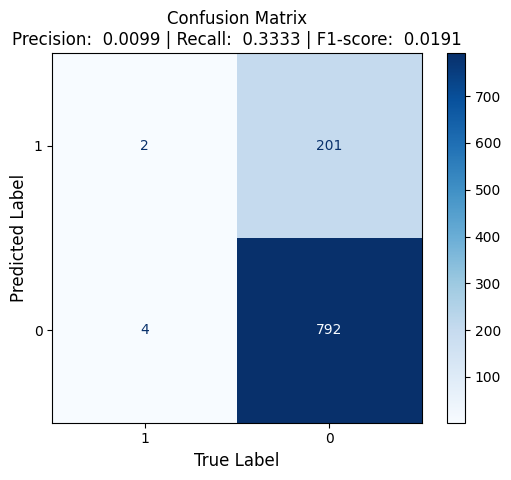

In [65]:

disp = ConfusionMatrixDisplay(nda_cm, display_labels=np.array([1, 0]))

# 設定顏色
disp.plot(cmap='Blues')

# 設定軸標題
plt.xlabel("True Label", fontsize=12)
plt.ylabel("Predicted Label", fontsize=12)

# 設定標題
score_string = f'Precision: {precision: .4f} | Recall: {recall: .4f} | F1-score: {f1: .4f}'
plt.title('Confusion Matrix\n' + score_string)

plt.show()

In [66]:
# 採用特徵
X_train.columns[lgs.coef_.flatten() > 0]

Index(['營業縣市_台東縣', '營業縣市_宜蘭縣', '營業縣市_新竹市', '營業縣市_桃園市', '營業縣市_高雄市', '場所型式_c',
       '是否兼具製造業', '投保責任險'],
      dtype='object')

### stepwise AIC (LinAlgError: Singular matrix)

In [ ]:
import statsmodels.api as sm

In [ ]:

cols_inclu = list(X.columns)
best_aic = None

# while True:

aic_with_rmCol = []

for col in cols_inclu: 
    cols_try = list(set(cols_inclu)-{col})
    X_train = sm.add_constant(X[cols_try])
    mdl = sm.Logit(y, X_train).fit()
    aic = mdl.aic
    aic_with_rmCol.append((aic, col))

aic_with_rmCol.sort()
best_rmCol_aic, best_rmCol = aic_with_rmCol[0]

    # if best_aic is None or best_rmCol_aic < best_aic: 
    #     best_aic = best_rmCol_aic
    #     cols_inclu.remove(best_rmCol)

    #     print(f'移除特徵：{best_rmCol}，AIC = {best_rmCol_aic:.4f}')
    # else: 
    #     break

